In [1]:
import sqlite3

import pandas as pd
from matplotlib import pyplot as plt

Reading the raw dataset.

In [2]:
connection = sqlite3.connect("../raw/commoncrawl_news_articles/articles.db")

df = pd.read_sql(
    "SELECT content_preprocessed, au.outlet_name FROM article_contents ac INNER JOIN article_urls au on ac.uuid = au.uuid WHERE language = 'en'",
    connection
)

outlets_df = pd.read_json(open("../raw/commoncrawl_news_articles/outlets.json"))
df = df.merge(outlets_df, how="outer", left_on="outlet_name", right_on="name")
df

,content_preprocessed,outlet_name,name,tld,filter,allsides_rating,allsides_name
0,Ukraine's president is pleading with citizens ...,ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
1,"Youtube\n“It’s a phenomenon, but so is the Her...",ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
2,Rep. Liz Cheney leaves House chamber with her ...,ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
3,"Will Smith, Lady Gaga and Ben Affleck landed i...",ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
4,Taiwan says 27 Chinese aircraft entered its ai...,ABC News,ABC News,abcnews.go.com,,lean left,ABC News (Online)
...,...,...,...,...,...,...,...
520799,"""I’m quite concerned,"" warned Goldman's Abby J...",ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge
520800,A recent report by the Middle East Media Resea...,ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge
520801,"It's that time again when Jeffrey Gundlach, th...",ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge
520802,"As we discussed yesterday, when looking at the...",ZeroHedge,ZeroHedge,zerohedge.com,,lean right,ZeroHedge


Dropping useless columns.

In [3]:
df = df.drop(columns=["outlet_name", "name", "tld", "filter", "allsides_name"])

Renaming columns.

In [4]:
df = df.rename(columns={"content_preprocessed": "body", "allsides_rating": "leaning"})

Categorizing the leaning column.

In [5]:
df["leaning"].unique()

array(['lean left', 'center', 'right', 'left', 'lean right'], dtype=object)

In [6]:
df["leaning"] = df["leaning"].replace({"lean left": "left", "lean right": "right"})
df["leaning"] = df["leaning"].astype("category")

Dropping rows with missing data.

In [7]:
df = df.dropna()

Printing duplicates.

In [8]:
df[df["body"].duplicated(keep=False)]

,body,leaning
3,"Will Smith, Lady Gaga and Ben Affleck landed i...",left
20,Interest Successfully Added\nWe'll notify you ...,left
22,Interest Successfully Added\nWe'll notify you ...,left
23,Interest Successfully Added\nWe'll notify you ...,left
25,Nissan Concept 2020 Vision Gran Turismo Nissan...,left
...,...,...
519702,Featured Photo Galleries\nGreatest gun-toting ...,right
519706,"** For in-depth results, click a county above....",right
519726,Featured Photo Galleries\nGreatest gun-toting ...,right
519729,Featured Photo Galleries\nGreatest gun-toting ...,right


Dropping the duplicates.

In [9]:
df = df.drop_duplicates(subset="body")

Replacing `<SENT_END>`s by spaces.

In [10]:
df["body"] = df["body"].str.replace("<SENT_END>", " ")

Inspecting body length.

In [11]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head()

,body,leaning,body_length,body_word_count
341484,"“I know it was your idea, but it was my idea t...",left,63,15
24119,"""We would only do it if it was a challenge, bu...",center,65,15
341092,"“Mom? For my birthday, can I have a jerk kid r...",left,66,15
356401,“I don’t tell you how to do your job—don’t tel...,left,67,15
351781,"“I’ll go to my room and do my homework, but I ...",left,68,16


After inspection, articles with bodies shorter than 50 words seem to contain no political value. Removing them.

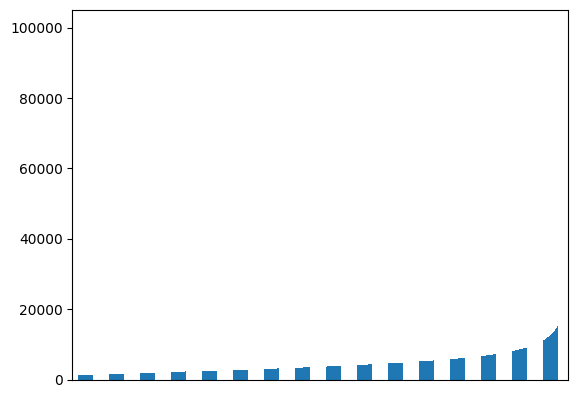

In [12]:
body_word_count_lower_bound = 50
df = df[df["body_word_count"] >= body_word_count_lower_bound]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df["body_length"].iloc[::100], df["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

In [13]:
df["body_length"].mean()

np.float64(4695.281589379658)

The leaning distribution.

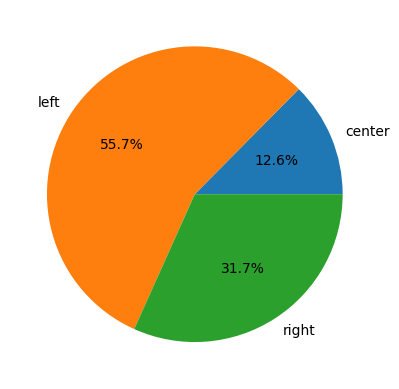

In [14]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

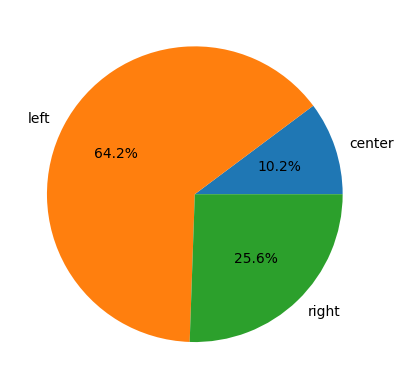

In [15]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution of left leaning articles.

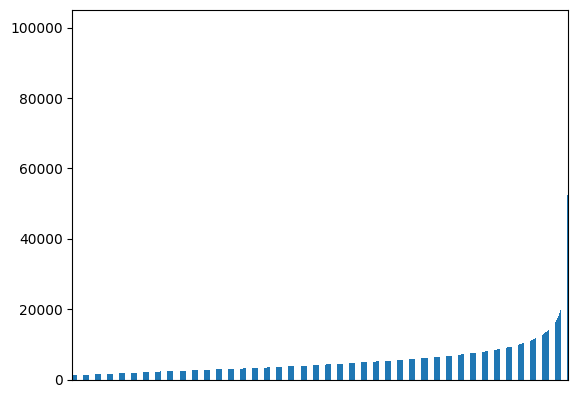

In [16]:
df_leaning = df[df["leaning"] == "left"]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df_leaning["body_length"].iloc[::100], df_leaning["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

Body length distribution by leaning.

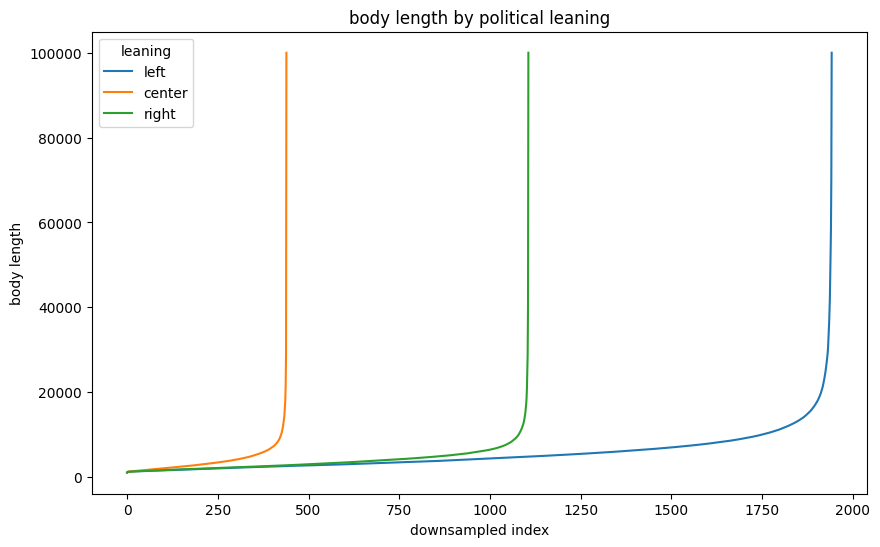

In [17]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::100], df_leaning["body_length"].tail(1)]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [18]:
df.to_parquet("../preprocessed/commoncrawl_news_articles.parquet")